<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/GNMR2023/EXSY.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

# Exchange Spectroscopy (EXSY)

In this first example, we simulate a system where the chemical shift exchanges between two frequencies according to an exchange matrix. We will then look how it results in a 2D EXSY spectrum, and how that spectrum changes as a function of a mixing time.

In [ ]:
!git clone https://github.com/alsinmr/ConferenceExamples.git
%cd /content/ConferenceExamples/GNMR2023
import setup

In [ ]:
#Sometimes, there is a delay between setup finishing and being able to complete the module loads
from importlib.machinery import SourceFileLoader
RS = SourceFileLoader("pyRelaxSim", "/content/pyRelaxSim/__init__.py").load_module()
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# # This cell is only for testing on my computer
# import sys
# sys.path.append('/Users/albertsmith/Documents/GitHub')
# sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
# import SLEEPY as RS
# import numpy as np
# import matplotlib.pyplot as plt
# RS.Defaults['parallel']=False

## Build the system
The first step is to build the system, which will have a single nucleus, with two different chemical shifts.

In [2]:
ex0=RS.ExpSys(Nucs='13C',v0H=600)    #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-5)   #Add the chemical shifts
ex1.set_inter(Type='CS',i=0,ppm=5)

## Add the exchange process
First, export this sytem into Liouville space, allowing us to introduce an exchange process. Then we'll define a correlation time and population 1 and population 2. From this we can build the exchange matrix and append it to the Liouvillian. We also add some T2 relaxation to destroy transverse magnetization during the delay period for exchange and produce some broadening.

In [3]:
L=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1     #Correlation time (10 s)
p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2

kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))
L.kex=kex

L.add_relax(Type='T2',i=0,T2=.01)

We can check the correlation time and equilibrium populations based on eigenvalue decomposition of the exchange matrix

In [4]:
d,v=np.linalg.eig(kex)
i=np.argsort(d)  # One element should be zero, the other negative
tc_k=-1/d[i[0]]
peq=v[:,i[1]]
peq/=peq.sum()
print(f'The correlation time is {tc_k:.1f} s, and the equilibrium populations are ({peq[0]:.2f},{peq[1]:.2f})')

The correlation time is 1.0 s, and the equilibrium populations are (0.75,0.25)


## Run as a 2D experiment
First, we'll just calculate one 2D spectrum, and then later check how the spectrum evolves as a function of a delay time. We need an initial density matrix, $S_x$, a detection matrix, $S^+$, and propagators for evolution times, $\pi$/2 pulses, and a delay for the exchange process. We start with generating the propagators and density matrices.

In [5]:
rho=RS.Rho(rho0='S0x',detect='S0p')

pi2x=RS.Sequence(L=L) #Pulse sequences for pi/2 pulses
pi2y=RS.Sequence(L=L)
pi2my=RS.Sequence(L=L)
pi2x.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=0)      #Here we add the pi/2 pulse on x
pi2y.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=np.pi/2) #Here we add the pi/2 pulse on y
pi2my.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=-np.pi/2) #Here we add the pi/2 pulse on y

Upi2x=pi2x.U()  #Get the propagators for the pulse sequence
Upi2y=pi2y.U()
Upi2my=pi2my.U()

Dt=1/(2*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 
Uevol=L.U(Dt=Dt)  #Propagator for the evolution time
Udelay=L.U(Dt=5) #Get the propagator for the delay (Here set to 5 seconds, i.e. full exchange)

## Execute the sequence
We need to capture both an indirect and direct dimension, with both real and imaginary components. We'll loop over the indirect dimension, and capture the direct dimension with Rho.DetProp

In [6]:
RE=list()
IM=list()
n=32
for k in range(n):
    rho.clear()
    #First capture the real part
    Uevol**k*rho  #This applies the evolution operator k times
    Upi2my*rho     #This flips the x magnetization up to z
    Udelay*rho     #This applies the delay for exchange to occur
    Upi2y*rho    #The flips the z magnetization back to x
    rho.DetProp(Uevol,n=n) #Detect the transverse (S0p) magnetization
    RE.append(rho.I[0])
    #Now capture the imaginary part
    rho.clear()
    Uevol**k*rho
    Upi2x*rho #Flip the y magnetization up to z
    Udelay*rho
    Upi2y*rho #Flip z magnetization back to x
    rho.DetProp(Uevol,n=n)
    IM.append(rho.I[0])

## Fourier transform and plot the results
We just extract the real part from the spectrum

In [7]:
RE,IM=np.array(RE,dtype=complex),np.array(IM,dtype=complex)
RE[:,0]/=2
RE[0,:]/=2
IM[:,0]/=2
IM[0,:]/=2
apod=np.cos(np.linspace(0,1,RE.shape[0])*np.pi/2)**2
RE=RE*apod
RE=(RE.T*apod).T
IM=IM*apod
IM=(IM.T*apod).T

Hypercomplex processing

In [8]:
nft=n*32
spec=np.fft.fftshift(np.fft.fft(np.fft.fft(RE,n=nft,axis=1).real.astype(complex)+1j*np.fft.fft(IM,n=nft,axis=1),n=nft,axis=0),axes=[0,1])
v=1/(2*Dt)*np.linspace(-1,1,spec.shape[0])  #Frequency axis
v-=(v[1]-v[0])/2  
v*=1e6/ex0.v0[0]   #convert to ppm
vx,vy=np.meshgrid(v,v)  #meshgrid for plotting

Plotting

<IPython.core.display.Javascript object>


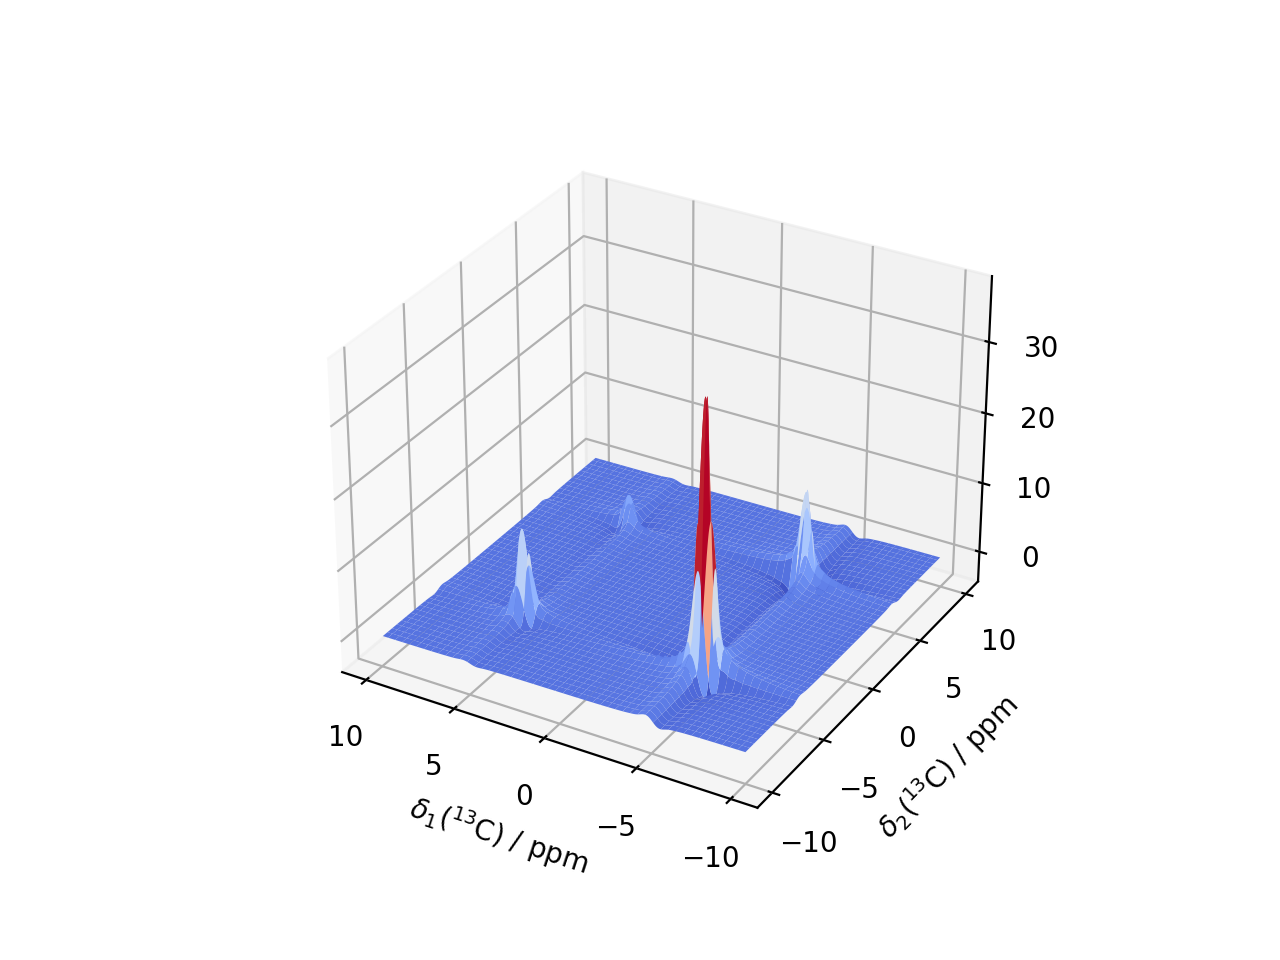

In [9]:
from matplotlib import cm
ax=plt.figure().add_subplot(111,projection='3d')
ax.plot_surface(vx,vy,spec.real,cmap=cm.coolwarm,linewidth=0,color='None')
ax.set_xlabel(r'$\delta_1 (^{13}$C) / ppm')
ax.set_ylabel(r'$\delta_2 (^{13}$C) / ppm')
ax.invert_xaxis()
ax.invert_yaxis()

## Sweep the delay time to observe buildup
We just repeat the above code except with different lengths for Udelay. We slice through the larger peak in order to see the growth of the second peak

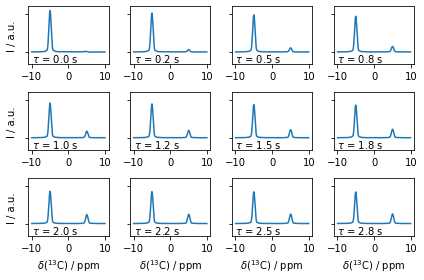

In [11]:
delays=np.linspace(0,3,13)[:-1]
fig,ax=plt.subplots(3,4)
ax=ax.reshape(ax.size)
sm=None
I=list()
for a,delay in zip(ax,delays):
    Udelay=L.U(Dt=delay)
    #Propagation
    RE=list()
    IM=list()
    for k in range(n):
        rho.clear()
        #First capture the real part
        Uevol**k*rho  #This applies the evolution operator k times
        Upi2my*rho     #This flips the x magnetization up to z
        Udelay*rho     #This applies the delay for exchange to occur
        Upi2y*rho    #The flips the z magnetization back to x
        rho.DetProp(Uevol,n=n) #Detect the transverse (S0p) magnetization
        RE.append(rho.I[0])
        #Now capture the imaginary part
        rho.clear()
        Uevol**k*rho
        Upi2x*rho #Flip the y magnetization up to z
        Udelay*rho
        Upi2y*rho #Flip z magnetization back to x
        rho.DetProp(Uevol,n=n)
        IM.append(rho.I[0])
    
    #Calculate spectrum
    RE,IM=np.array(RE,dtype=complex),np.array(IM,dtype=complex)
    RE[:,0]/=2
    RE[0,:]/=2
    IM[:,0]/=2
    IM[0,:]/=2
    RE=RE*apod
    RE=(RE.T*apod).T
    IM=IM*apod
    IM=(IM.T*apod).T
    spec=np.fft.fftshift(np.fft.fft(np.fft.fft(RE,n=nft,axis=1).real.astype(complex)+\
                                    1j*np.fft.fft(IM,n=nft,axis=1),n=nft,axis=0),axes=[0,1])
    v=1/(2*Dt)*np.linspace(-1,1,spec.shape[0])  #Frequency axis
    v-=(v[1]-v[0])/2  
    v*=1e6/ex0.v0[0]   #convert to ppm
    
    #Plot the result
    integral=spec[:,100:400].sum(1).real
    if sm is None:
        sm=integral.max()
    
    a.plot(v,integral)
    if a.is_last_row() if hasattr(a,'is_last_row') else a.get_subplotspec().is_last_row():
        a.set_xlabel(r'$\delta (^{13}$C) / ppm')
    if a.is_first_col() if hasattr(a,'is_first_col') else a.get_subplotspec().is_first_col():
        a.set_ylabel('I / a.u.')
    a.set_ylim([-sm*.3,sm*1.1])
    a.text(-10,-sm*.25,r'$\tau$'+f' = {delay:.1f} s')
    a.set_yticklabels('')
    
    I.append([spec[100:400][:,100:400].real.sum(),spec[600:900][:,600:900].real.sum(),
              spec[100:400][:,600:900].real.sum(),spec[600:900][:,100:400].real.sum()])  #Collect individual peak intensities
I=np.array(I).T   #Collection of individual peak intensities
fig.tight_layout()

## Plot trajectory of the individual peaks
Each peak represents the probability of starting in some state and ending in another state after the delay time, $\tau$

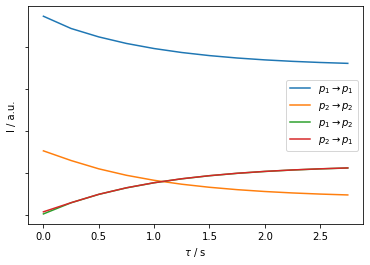

In [12]:
ax=plt.subplots()[1]
ax.plot(delays,I.T)
ax.set_xlabel(r'$\tau$ / s')
ax.set_ylabel('I / a.u.')
ax.set_yticklabels('')
ax.legend((r'$p_1\rightarrow p_1$',r'$p_2\rightarrow p_2$',r'$p_1\rightarrow p_2$',r'$p_2\rightarrow p_1$'))

## Spectra as a function of exchange rate
We can't use EXSY for faster motions, because the peaks don't stay separated. We can observe this behavior here. We just copy the setup from above for the 3D spectra and run it with varying correlation times

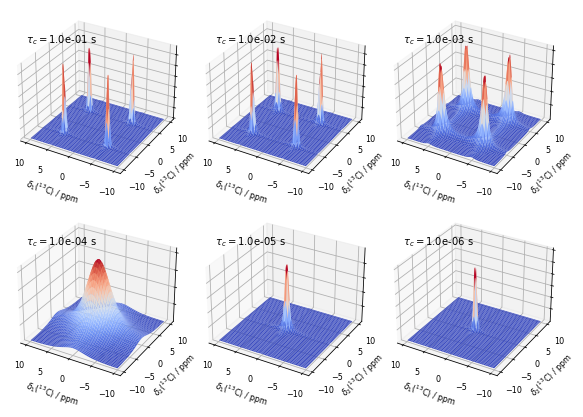

In [15]:
tc0=np.logspace(-1,-6,6)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

fig=plt.figure()
ax=[fig.add_subplot(2,3,k+1,projection='3d') for k in range(6)]
I=list()
for a,tc in zip(ax,tc0):
    L.kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))
    
    Upi2x=pi2x.U()  #Get the propagators for the pulse sequence
    Upi2y=pi2y.U()
    Upi2my=pi2my.U()
    
    Udelay=L.U(Dt=tc0[0]*5)
    Uevol=L.U(Dt=Dt)  #Propagator for the evolution time
    
    #Propagation
    RE=list()
    IM=list()
    for k in range(n):
        rho.clear()
        #First capture the real part
        Uevol**k*rho  #This applies the evolution operator k times
        Upi2my*rho     #This flips the x magnetization up to z
        Udelay*rho     #This applies the delay for exchange to occur
        Upi2y*rho    #The flips the z magnetization back to x
        rho.DetProp(Uevol,n=n) #Detect the transverse (S0p) magnetization
        RE.append(rho.I[0])
        #Now capture the imaginary part
        rho.clear()
        Uevol**k*rho
        Upi2x*rho #Flip the y magnetization up to z
        Udelay*rho
        Upi2y*rho #Flip z magnetization back to x
        rho.DetProp(Uevol,n=n)
        IM.append(rho.I[0])
    
    #Calculate spectrum
    RE,IM=np.array(RE,dtype=complex),np.array(IM,dtype=complex)
    RE[:,0]/=2
    RE[0,:]/=2
    IM[:,0]/=2
    IM[0,:]/=2
    RE=RE*apod
    RE=(RE.T*apod).T
    IM=IM*apod
    IM=(IM.T*apod).T
    spec=np.fft.fftshift(np.fft.fft(np.fft.fft(RE,n=nft,axis=1).real+\
                                    1j*np.fft.fft(IM,n=nft,axis=1),n=nft,axis=0).real,axes=[0,1])
    v=1/(2*Dt)*np.linspace(-1,1,spec.shape[0])  #Frequency axis
    v-=(v[1]-v[0])/2  
    v*=1e6/ex0.v0[0]   #convert to ppm
    
    #Plot the result
    a.plot_surface(vx,vy,spec.real,cmap=cm.coolwarm,linewidth=0,color='None')
    a.set_xlabel(r'$\delta_1 (^{13}$C) / ppm',fontsize=8)
    a.set_ylabel(r'$\delta_2 (^{13}$C) / ppm',fontsize=8)
    a.tick_params(axis='both', which='major', labelsize=8)
    a.invert_xaxis()
    a.invert_yaxis()
    a.text(10,-10,a.get_zlim()[1]*1.3,r'$\tau_c = $'+f'{tc:.1e} s')
    
fig.set_size_inches(8,6)
fig.tight_layout()
for a in ax:a.set_zticklabels('')

Now we do the same as above, but without having symmetric exchange, i.e. $p_1\ne p_2$. The unusual lineshape remaining at 2.5 ppm is a ghost peak of the -2.5 ppm peak (incomplete phase cycle), and not a remaining signal from exchange.

<IPython.core.display.Javascript object>


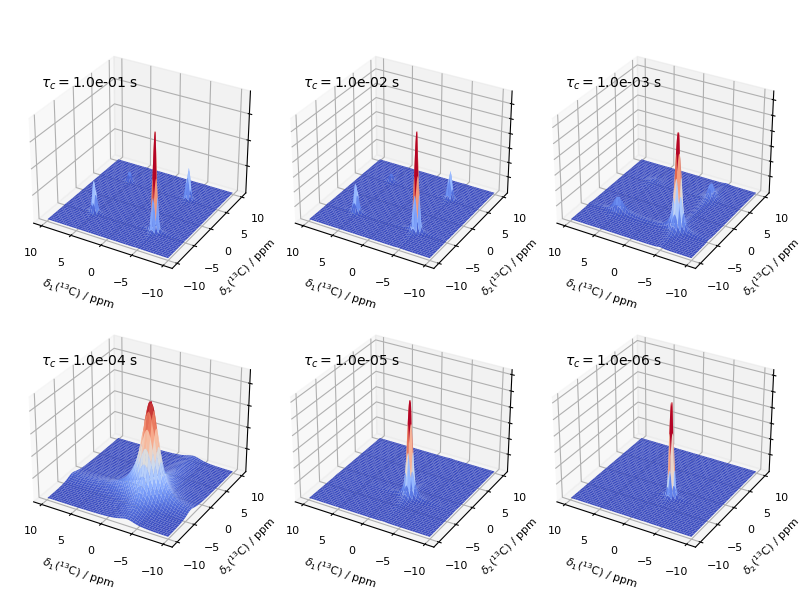

In [18]:
tc0=np.logspace(-1,-6,6)
p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2

fig=plt.figure()
ax=[fig.add_subplot(2,3,k+1,projection='3d') for k in range(6)]
I=list()
for a,tc in zip(ax,tc0):
    L.kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))
    
    Upi2x=pi2x.U()  #Get the propagators for the pulse sequence
    Upi2y=pi2y.U()
    Upi2my=pi2my.U()
    
    Udelay=L.U(Dt=tc0[0]*5)
    Uevol=L.U(Dt=Dt)  #Propagator for the evolution time
    
    #Propagation
    RE=list()
    IM=list()
    for k in range(n):
        rho.clear()
        #First capture the real part
        Uevol**k*rho  #This applies the evolution operator k times
        Upi2my*rho     #This flips the x magnetization up to z
        Udelay*rho     #This applies the delay for exchange to occur
        Upi2y*rho    #The flips the z magnetization back to x
        rho.DetProp(Uevol,n=n) #Detect the transverse (S0p) magnetization
        RE.append(rho.I[0])
        #Now capture the imaginary part
        rho.clear()
        Uevol**k*rho
        Upi2x*rho #Flip the y magnetization up to z
        Udelay*rho
        Upi2y*rho #Flip z magnetization back to x
        rho.DetProp(Uevol,n=n)
        IM.append(rho.I[0])
    
    #Calculate spectrum
    RE,IM=np.array(RE,dtype=complex),np.array(IM,dtype=complex)
    RE[:,0]/=2
    RE[0,:]/=2
    IM[:,0]/=2
    IM[0,:]/=2
    RE=RE*apod
    RE=(RE.T*apod).T
    IM=IM*apod
    IM=(IM.T*apod).T
    spec=np.fft.fftshift(np.fft.fft(np.fft.fft(RE,n=nft,axis=1).real+\
                                    1j*(np.fft.fft(IM,n=nft,axis=1).real),n=nft,axis=0),axes=[0,1])
    v=1/(2*Dt)*np.linspace(-1,1,spec.shape[0])  #Frequency axis
    v-=(v[1]-v[0])/2  
    v*=1e6/ex0.v0[0]   #convert to ppm
    
    #Plot the result
    a.plot_surface(vx,vy,spec.real,cmap=cm.coolwarm,linewidth=0,color='None')
    a.set_xlabel(r'$\delta_1 (^{13}$C) / ppm',fontsize=8)
    a.set_ylabel(r'$\delta_2 (^{13}$C) / ppm',fontsize=8)
    a.tick_params(axis='both', which='major', labelsize=8)
    a.invert_xaxis()
    a.invert_yaxis()
    a.text(10,-10,a.get_zlim()[1]*1.3,r'$\tau_c = $'+f'{tc:.1e} s')
    

fig.set_size_inches(8,6)
fig.tight_layout()
for a in ax:a.set_zticklabels('')